In [1]:
from pathlib import Path

if Path.cwd().stem == "features":
    %cd ../..
    %load_ext autoreload
    %autoreload 2

/Users/visser/drive/PhD/Code/pain-measurement


In [2]:
import logging
import os
from dataclasses import dataclass
from functools import reduce, wraps
from pathlib import Path
from typing import Dict, List

import holoviews as hv
import hvplot.polars
import matplotlib.pyplot as plt
import neurokit2 as nk
import numpy as np
import pandas as pd
import panel as pn
import plotly.express as px
import polars as pl

from src.data.config_data import DataConfigBase
from src.data.config_data_raw import RAW_DICT, RAW_LIST, RawConfig
from src.data.config_participant import (
    PARTICIPANT_DICT,
    PARTICIPANT_LIST,
    ParticipantConfig,
)
from src.data.make_dataset import load_dataset, load_participant_datasets
from src.features.quality_checks import check_sample_rate
from src.features.transformations import (
    add_timedelta_column,
    interpolate,
    map_participant_datasets,
    map_trials,
    merge_dfs,
    scale_min_max,
    scale_standard,
)
from src.log_config import configure_logging
from src.visualization.plot_data import plot_data_panel, plot_trial_matplotlib
from src.visualization.plotting_utils import concat_participants_on_modality

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado", "param"],
)

pl.Config.set_tbl_rows(7)  # don't print too many rows in the book
plt.rcParams["figure.figsize"] = [15, 5]  # default is [6, 4]

In [6]:
participant_number = 0
modality = "eda"
data_config = RAW_DICT[modality]
sampling_rate = 100  # data_config.sampling_rate

eda_raw = load_dataset(PARTICIPANT_LIST[participant_number], RAW_DICT[modality]).dataset
heat = load_dataset(PARTICIPANT_LIST[participant_number], RAW_DICT["heat"]).dataset

eda_raw = eda_raw  # .unique('Timestamp').sort('Timestamp') # actually slightly faster than maintain_order=True
logging.warning("Working with unique timestamps.")

check_sample_rate(eda_raw)
check_sample_rate(eda_raw, unique_timestamp=True)

15:12:50 | DEBUG   | process_data | Dataset 'eda' for participant 005_leo loaded from data/raw/005_leo/005_leo_eda.csv
15:12:50 | DEBUG   | process_data | Dataset 'heat' for participant 005_leo loaded from data/raw/005_leo/005_leo_heat.csv
15:12:50 | WARNING | root | Working with unique timestamps.
15:12:50 | DEBUG   | quality_check | Sample rate per trial: [255.99 256.05 256.02 255.98 256.01 256.01 256.01 256.02 256.02 256.04
 256.01 256.03]
15:12:50 | INFO    | quality_check | The mean sample rate is 256.02.
15:12:50 | INFO    | quality_check | Checking sample rate for unique timestamps.
15:12:50 | DEBUG   | quality_check | Sample rate per trial: [106.88 106.83 107.94 108.65 107.91 107.86 108.18 107.66 108.47 107.87
 108.49 107.89]
15:12:50 | INFO    | quality_check | The mean sample rate is 107.89.
15:12:50 | WARNING | quality_check | Sample rate varies more than 0.5% between trials: 0.53% (coefficient of variation).


In [7]:
eda_raw_participants = []
for idx, participant in enumerate(PARTICIPANT_LIST):
    eda_raw_participants.append(
        load_dataset(participant, data_config).dataset.with_columns(
            pl.lit(idx).alias("Participant")
        )
    )

edas = pl.concat(eda_raw_participants)
edas

15:13:17 | DEBUG   | process_data | Dataset 'eda' for participant 005_leo loaded from data/raw/005_leo/005_leo_eda.csv


Timestamp,EDA_RAW,Trial,Participant
f64,f64,f64,i32
65974.137,7.017141,0.0,0
65974.137,7.022246,0.0,0
65974.137,7.022246,0.0,0
…,…,…,…
3.1588e6,8.237291,11.0,0
3.1588e6,8.242396,11.0,0
3.1588e6,8.242396,11.0,0


In [ ]:
plot_data_panel(edas)  # , groups="Participant")

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

INFO:bokeh.server.server:Starting Bokeh server version 3.3.3 (running on Tornado 6.3.3)
INFO:bokeh.server.tornado:User authentication hooks NOT provided (default user enabled)
DEBUG:bokeh.server.tornado:These host origins can connect to the websocket: ['localhost:32059']
DEBUG:bokeh.server.tornado:Patterns are:
DEBUG:bokeh.server.tornado:  [('/favicon.ico',
DEBUG:bokeh.server.tornado:    <class 'bokeh.server.views.ico_handler.IcoHandler'>,
DEBUG:bokeh.server.tornado:    {'app': <bokeh.server.tornado.BokehTornado object at 0x12f5f2d10>}),
DEBUG:bokeh.server.tornado:   ('/?',
DEBUG:bokeh.server.tornado:    <class 'panel.io.server.DocHandler'>,
DEBUG:bokeh.server.tornado:    {'application_context': <bokeh.server.contexts.ApplicationContext object at 0x12f61a3d0>,
DEBUG:bokeh.server.tornado:     'bokeh_websocket_path': '/ws'}),
DEBUG:bokeh.server.tornado:   ('/ws',
DEBUG:bokeh.server.tornado:    <class 'bokeh.server.views.ws.WSHandler'>,
DEBUG:bokeh.server.tornado:    {'application_context

Launching server at http://localhost:32059


INFO:tornado.access:200 GET / (127.0.0.1) 89.23ms
INFO:tornado.access:200 GET /static/extensions/panel/bundled/jquery/jquery.slim.min.js (127.0.0.1) 1.13ms
INFO:tornado.access:200 GET /static/extensions/panel/bundled/plotlyplot/plotly-2.25.2.min.js (127.0.0.1) 7.37ms
INFO:tornado.access:200 GET /static/js/bokeh.min.js?v=f43c49e86dc38c1a13b9f41aad15fb57c3b2f70844817e5559b32d9e0a177c319416281f7bac18181198884ceb3998420b37b2b0199e0d0dc6485e34fc0a28dc (127.0.0.1) 7.99ms
INFO:tornado.access:200 GET /static/js/bokeh-gl.min.js?v=bf37f0b457d54fefb6ca8423c37db6ae69479153907d223a22f57d090b957998e75abda056bf5b0916a24f99930fa6df3b242a1a3a0986b549fbc966c1e04416 (127.0.0.1) 1.33ms
INFO:tornado.access:200 GET /static/js/bokeh-widgets.min.js?v=3c2dbaf226dc96c10bf3dfbcde30557363d2c16ec86bf2a10fb615e53d3971cbcf801e5051aa500292ec49f54812deae2aec9aaad0d97331534c89fe18ede89a (127.0.0.1) 1.09ms
INFO:tornado.access:200 GET /static/js/bokeh-tables.min.js?v=7849f2320ea741465a49857765873105e961ae71f15b481c5c529e

In [ ]:
eda_raw_trials = [
    group.select("EDA_RAW").to_numpy().flatten()
    for _, group in eda_raw.group_by(["Trial"])
]
eda_raw_trial = eda_raw_trials[0]

"""Same as:
# Get each trial as a separate np.array
groups = eda_raw.group_by(["Trial"], maintain_order=True)
eda_raw_trials = []
for _, group in groups:
    eda_raw_trials.append(group.select('EDA_RAW').to_numpy().flatten())
""";

In [ ]:
eda_raw.plot(x="Timestamp", y="EDA_RAW")

:Curve   [Timestamp]   (EDA_RAW)

In [ ]:
eda_raw

Timestamp,EDA_RAW,Trial
f64,f64,f64
27518.1013,9.151128,0.0
27539.0432,9.146022,0.0
27550.0157,9.140917,0.0
…,…,…
912465.2474,11.928374,2.0
912477.2154,11.928374,2.0
912480.211,11.918163,2.0


## neurokit

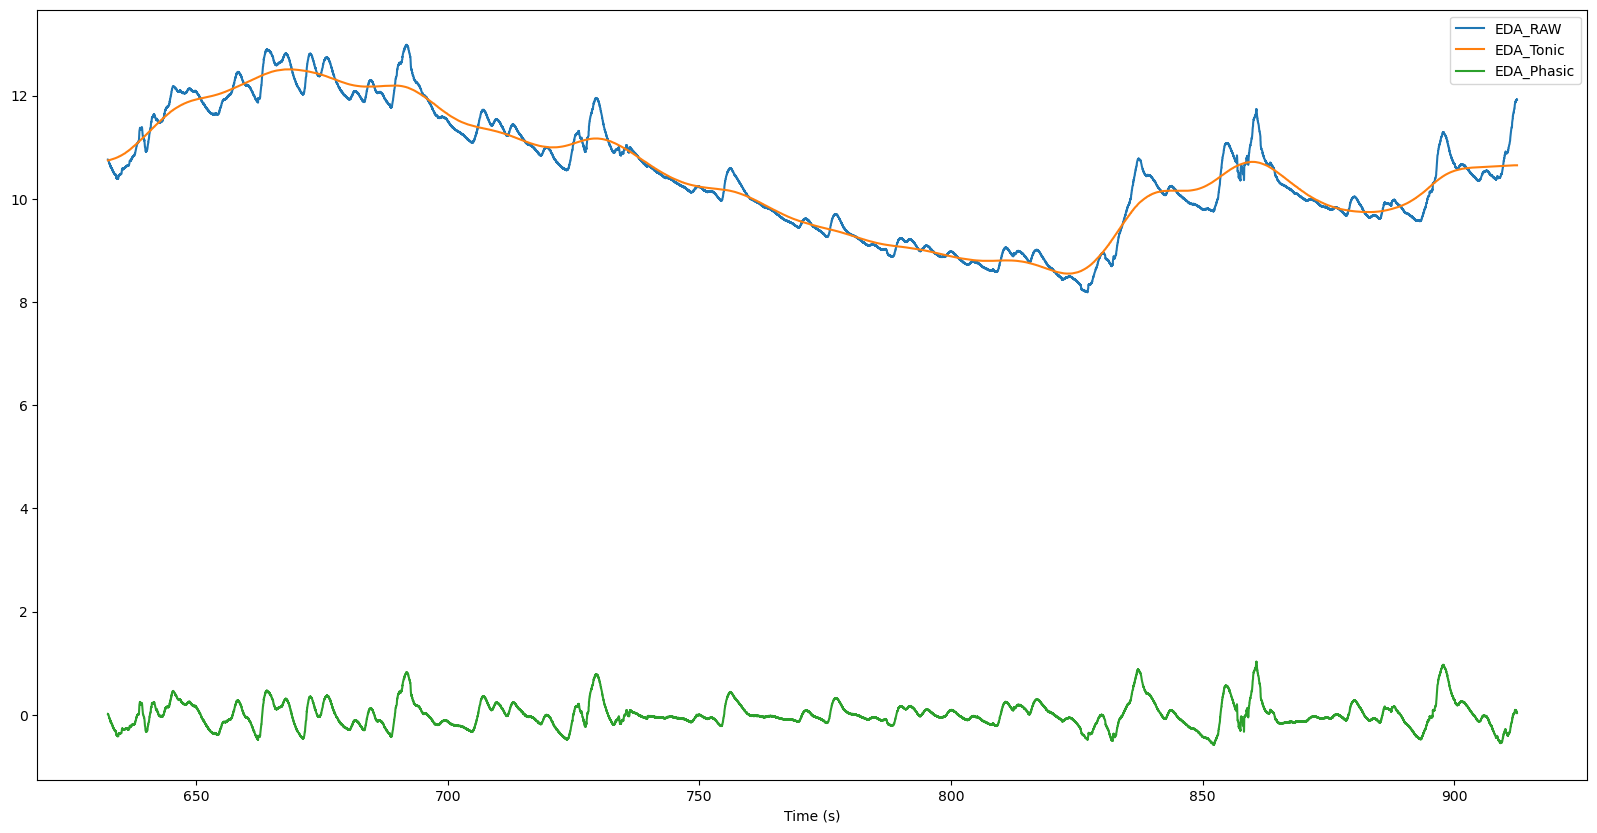

In [ ]:
@map_trials
def eda_process(df: pl.DataFrame, sampling_rate) -> pl.DataFrame:
    eda_raw_np = df.select("EDA_RAW").to_numpy().flatten()
    eda_processed_pd = nk.eda_phasic(
        eda_raw_np, sampling_rate=sampling_rate, method="neurokit"
    )
    return df.hstack(pl.from_pandas(eda_processed_pd))


eda2 = eda_process(eda_raw, sampling_rate=sampling_rate)

eda2
plot_trial_matplotlib(eda2, 2)

# Plot

In [ ]:
merged = merge_dfs(eda, temperature, rating)
merged = scale_min_max(merged)
merged = interpolate(merged)
merged

Timestamp,EDA_RAW,Trial,nk_EDA_Tonic,nk_EDA_Phasic,Temperature,Rating
f64,f64,f64,f64,f64,f64,f64
27518.1013,0.841758,0.0,0.970798,0.520562,0.0,0.429496
27539.0432,0.83956,0.0,0.970812,0.515307,0.0,0.429496
27550.0157,0.837363,0.0,0.970827,0.510038,0.0,0.429496
…,…,…,…,…,…,…
912465.2474,0.779787,2.0,0.536369,0.38485,0.859649,0.776244
912477.2154,0.779787,2.0,0.53637,0.381959,0.859649,0.776244
912480.211,0.77766,2.0,0.53637,0.379022,0.859649,0.776244


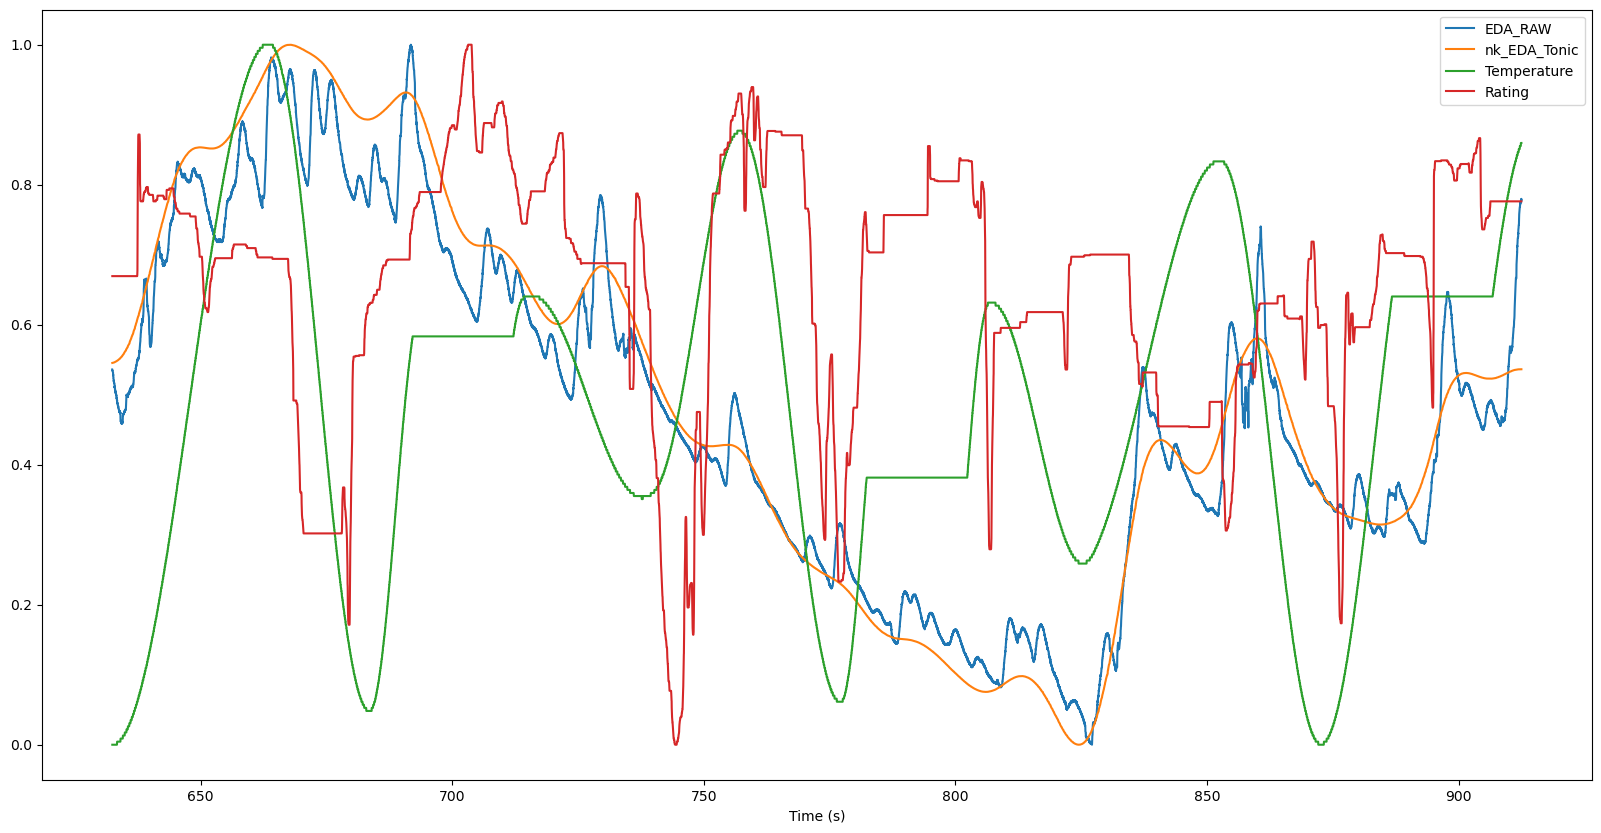

In [ ]:
plot_trial_matplotlib(merged.drop("nk_EDA_Phasic"), trial=2)

In [ ]:
def plot_data_panel(df: pl.DataFrame, features: List[str] = None):
    """
    To exclude a feature, simply use df.drop(feature)

    TODO: grouped legend? https://community.plotly.com/t/plots-with-grouped-legend/71864

    The following code would make life easier, but needs jupyter_bokeh to supports jupyter 4.0 first
    import hvplot
    hvplot.extension('plotly')
    eda.plot(x='Timestamp', y=['EDA_RAW', 'nk_EDA_Tonic', 'nk_EDA_Phasic'], groupby='Trial')
    """
    if features is None:
        features = df.drop("Timestamp", "Time", "Trial").columns

    # Explicitly tell hvPlot to use Plotly
    hv.extension("plotly")

    # maybe try in bokeh
    plot = df.hvplot(
        x="Timestamp",
        y=features,
        groupby=["Trial", "Participant"],
        backend="plotly",
        width=1400,
        height=600,
    )

    # Convert the plot to a Panel object
    panel = pn.panel(plot)

    # Serve the Panel object
    panel.show(port=np.random.randint(10000, 60000))


plot_data_panel(merged)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

ValueError: The supplied groupby dimension(s) ['Participant'] could not be found, expected one or more of: ['nk_EDA_Phasic', 'Rating', 'nk_EDA_Tonic', 'Timestamp', 'EDA_RAW', 'Temperature', 'Trial']